In [24]:
#Goal: Create word vectors from a Game of Thrones dataset
#and analyze them to semantic similarity

#Step 0 - Import dependencies
#future is the missing compatibility layer between Python 2 and Python 3. 
#It allows you to use a single, clean Python 3.x-compatible codebase to 
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#for word encoding
import codecs
#regex, matches pathnames
import glob
#concurrency
import multiprocessing
#dealing with operating system, like reading a file
import os
#pretty printing, human readable
import pprint
#regular expressions
import re
#natural language toolkit
import nltk
#word 2 vec
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy
import matplotlib.pyplot as plt
#parse pandas as pad
import pandas as pd
#visualization
import seaborn as sns

In [32]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Step 1 - Process our data
#clean data
nltk.download('punkt') #pretrained tokenizer
nltk.download('stopwords') #words like and, the, an, a, of remove common words

[nltk_data] Downloading package punkt to /Users/linguini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linguini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#get the book names, matching txt file
book_filenames = sorted(glob.glob("./*.txt"))

In [4]:
#print books
print("Found books:")
book_filenames

Found books:


['./got1.txt', './got2.txt', './got3.txt', './got4.txt', './got5.txt']

In [5]:
#initialize rawunicode, we'll add all text to this on file in memory
corpus_raw = u""
#for each book, read it, open it in utf 8 format,
#add it to the raw corpus
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} character")

Reading './got1.txt'...
Corpus is now {0} character
Reading './got2.txt'...
Corpus is now {0} character
Reading './got3.txt'...
Corpus is now {0} character
Reading './got4.txt'...
Corpus is now {0} character
Reading './got5.txt'...
Corpus is now {0} character


In [6]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [7]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [8]:
#covert into a list of words
#remove unnecessary, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]", " ", raw)
    words = clean.split()
    return words

In [9]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [10]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [11]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


## Train Word2Vec

In [12]:
#Step 3 - Build model

#Once we have vectors
#3 main tasks that vectors help with
#Distance, similarity, ranking

#Dimensionality of the resulting word vectors
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimsions = more generalized
num_features = 300

#Minimum word count threshold
min_word_count = 3

#Number of threads to run in parallel
#more workers, the faster we train
num_workers = multiprocessing.cpu_count()

#Context window length
context_size = 7

#Downsample setting for frequent words
#0 - 1e-5 is good for this
downsampling = 1e-3

#Seed for the RNG, to make the results reproducible
#random number generator
#deterministic, good for debugging
seed = 1

In [13]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [14]:
thrones2vec.build_vocab(sentences)

In [15]:
print("Word2Vec Vocabulary Length:", len(thrones2vec.vocab))

Word2Vec Vocabulary Length: 17277


In [16]:
thrones2vec.train(sentences)

7021151

#### Save to file for later use 

In [17]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [18]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

## Explore the trained model

In [3]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

In [4]:
#squash dimensionality to 2
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [5]:
all_word_vectors_matrix = thrones2vec.syn0

### Train t-SNE

In [6]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

#### Plot the big picture

In [33]:
#plot point in 2d space
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.vocab[word].index])
            for word in thrones2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [34]:
points.head(10)

,word,x,y
0,This,2.969577,0.501665
1,edition,-0.980018,5.353462
2,the,-0.698379,-1.993255
3,complete,0.008824,-1.948664
4,of,-2.581743,-1.920146
5,original,-0.053097,0.969836
6,hardcover,-1.377761,4.789581
7,ONE,-4.726936,-0.739217
8,A,0.929358,-2.850579
9,OF,-1.125177,5.521021


In [35]:
#plot
sns.set_context("poster")

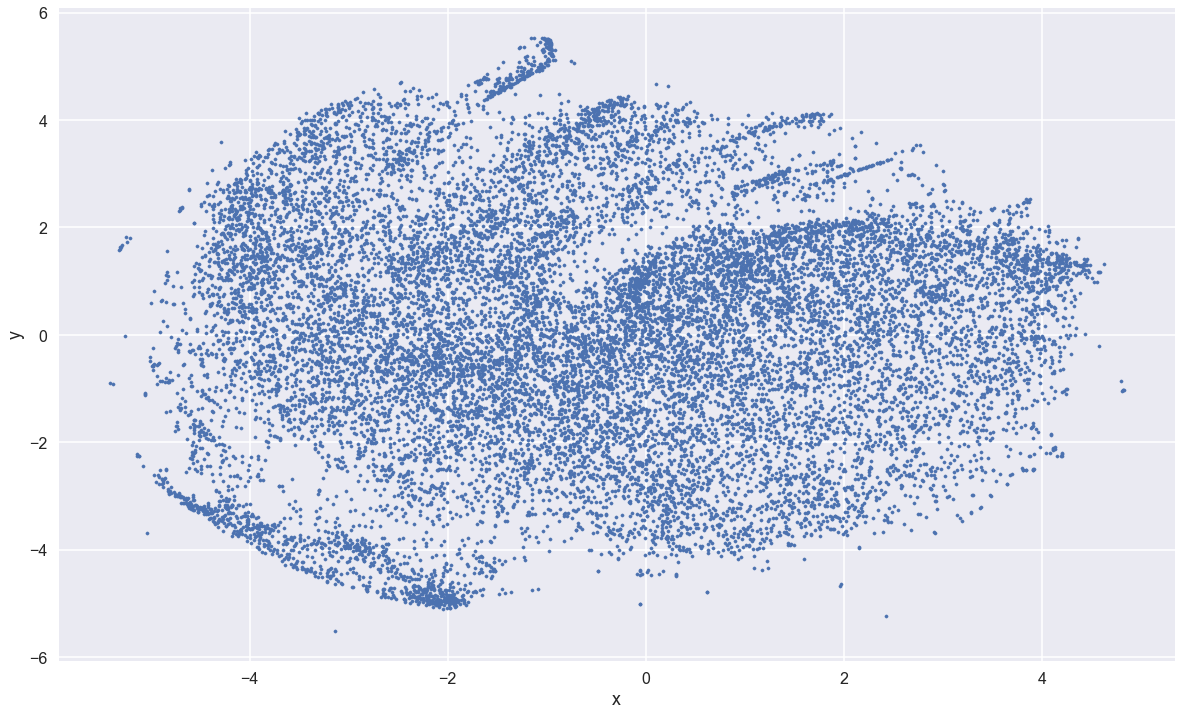

In [36]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [37]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

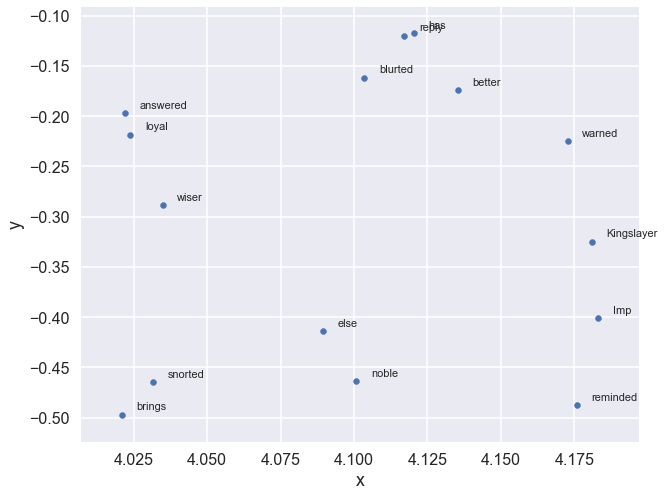

In [38]:
plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))

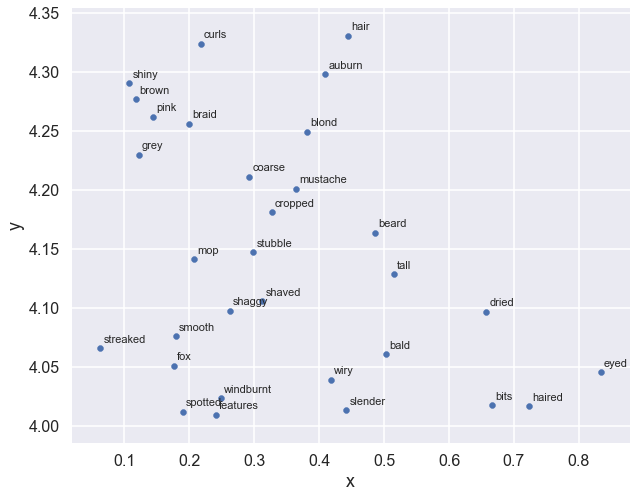

In [39]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

In [40]:
thrones2vec.most_similar("Stark")

[('Eddard', 0.7238768339157104),
 ('Winterfell', 0.6653619408607483),
 ('Lyanna', 0.6458801627159119),
 ('Robb', 0.6380823254585266),
 ('beheaded', 0.6334826946258545),
 ('Karstark', 0.6299595832824707),
 ('Benjen', 0.618538498878479),
 ('executed', 0.6145840287208557),
 ('direwolf', 0.6115704774856567),
 ('Brandon', 0.6071946620941162)]

In [41]:
thrones2vec.most_similar("Aerys")

[('Jaehaerys', 0.7887820601463318),
 ('Daeron', 0.7686640024185181),
 ('Unworthy', 0.7378884553909302),
 ('Mad', 0.7358270287513733),
 ('Elia', 0.7231391072273254),
 ('Rhaegar', 0.7209930419921875),
 ('Beggar', 0.7201461791992188),
 ('Maekar', 0.7168418765068054),
 ('Cruel', 0.7111786603927612),
 ('II', 0.7090158462524414)]

In [42]:
thrones2vec.most_similar("direwolf")

[('wolf', 0.6738012433052063),
 ('Ghost', 0.6615560054779053),
 ('Rickon', 0.649177074432373),
 ('SHAGGYDOG', 0.6381027698516846),
 ('pup', 0.6176599860191345),
 ('GHOST', 0.612148642539978),
 ('Stark', 0.6115704774856567),
 ('Val', 0.6020772457122803),
 ('Robb', 0.5987697839736938),
 ('ranger', 0.5965036749839783)]

In [43]:
#distance, similarity, and ranking
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [44]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as drank is related to wine
Arya is related to Nymeria, as Dany is related to dragons


'Dany'